# Analiza življenskih standardov po svetu

In [2]:
import pandas as pd
import os.path
import re
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pd.options.display.max_rows = 10
#%matplotlib notebook
%matplotlib inline

# naložimo razpredelnico, s katero bomo delali
pot_do_drzav = os.path.join("drzave.csv")
drzave = pd.read_csv(pot_do_drzav)
drzave = drzave.set_index('drzava')

### Obdelava podatkov

Tabeli dodamo stolpec 'gostota prebivalstva' ter '% uporabnikov interneta' in odstranimo stolpce, ki jih ne bomo potrebovali.

prekomerno tezki:povprecna starost:bdp
uporabniki interneta:tezki
izobrazba:internet
izobrazba:bdp
st restavracij:izbrazba
gostota:bdp:starost
povprecna starost : internet
starost zenske:moski --> plus top drzave?


In [3]:
drzave['gostota prebivalstva'] = round(drzave['prebivalstvo']/drzave['povrsina [km^2]'], 1)
drzave['% uporabnikov interneta'] = round(drzave['st uporabnikov interneta']/drzave['prebivalstvo'], 3)*100
drzave = drzave.iloc[:, [2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14]].drop(['EU'])

drzave

,povprecna starost,starost moski,starost zenske,% prekomero tezkih,indeks izobrazbe 2015,poraba energije [vat],st restavracij na 100k ljudi,bdp 2020,povprecni vnos kcal,gostota prebivalstva,% uporabnikov interneta
drzava,,,,,,,,,,,
Afghanistan,19.5,19.4,19.5,5.5,0.398,18.0,NaN,499.0,NaN,59.6,10.5
Albania,34.3,32.9,35.7,21.7,0.715,194.0,NaN,4898.0,2890.0,105.0,73.2
Algeria,28.9,28.6,29.3,27.4,0.658,164.0,NaN,3331.0,3090.0,18.4,44.9
American Samoa,NaN,NaN,NaN,NaN,NaN,313.0,NaN,NaN,NaN,NaN,NaN
Andorra,46.2,46.3,46.1,25.6,0.718,739.0,6.4,NaN,NaN,164.4,98.5
...,...,...,...,...,...,...,...,...,...,...,...
West Bank,NaN,NaN,NaN,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN
West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2894.0,NaN,NaN,NaN
Yemen,19.8,19.6,19.9,17.1,0.350,10.0,NaN,645.0,2050.0,56.5,25.3


### Analiza

# starost

Text(0, 0, 'Monaco')

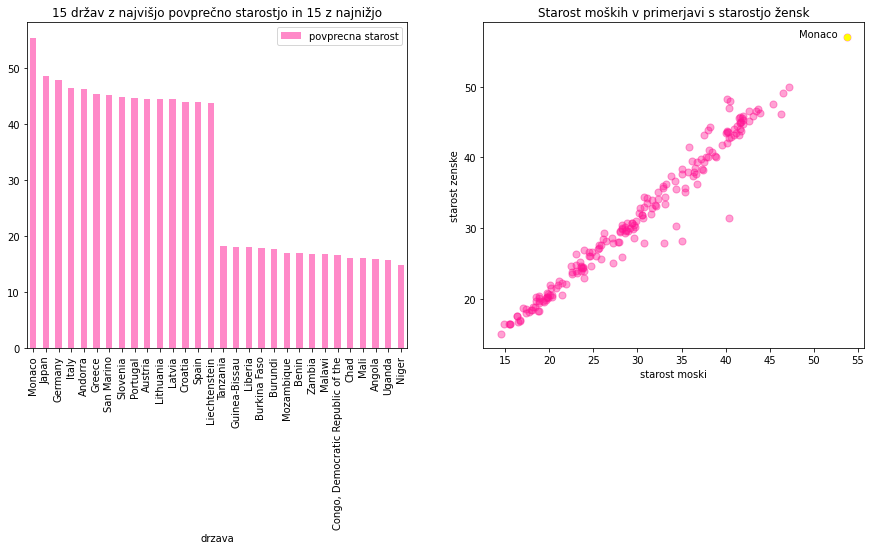

In [20]:
d_top = drzave.sort_values('povprecna starost', ascending=False).head(15)
d_bot = drzave.sort_values('povprecna starost', ascending=True).head(15).sort_values(by = 'povprecna starost', ascending=False)
izbrane = pd.concat([d_top, d_bot])
maksi = drzave.loc[drzave['starost moski'] == max(drzave['starost moski'])]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))

izbrane.plot.bar(y='povprecna starost', color = 'deeppink', alpha = 0.5, ax = ax1, title = '15 držav z najvišjo povprečno starostjo in 15 z najnižjo')
drzave.plot.scatter('starost moski', 'starost zenske', c = 'deeppink', alpha = 0.4, s= 50, ax = ax2, title = 'Starost moških v primerjavi s starostjo žensk')
plt.scatter(maksi['starost moski'], maksi['starost zenske'], c = 'yellow')
ax2.annotate(maksi.index.tolist()[0], (maksi['starost moski']-1, maksi['starost zenske']), size=10, xytext=(0,0), ha='right', textcoords='offset points')

# debelina

<AxesSubplot:title={'center':'odstotek prekomerno tezkih v primerjavi z delezom uporabnikov interneta'}, xlabel='% uporabnikov interneta', ylabel='% prekomero tezkih'>

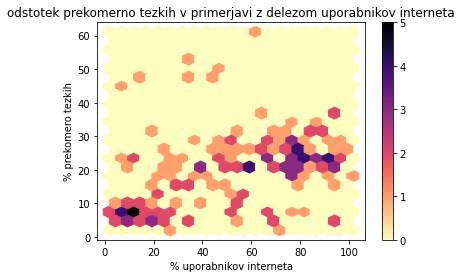

In [64]:
color_map = plt.cm.get_cmap('magma').reversed()

drzave.plot.hexbin('% uporabnikov interneta', '% prekomero tezkih', gridsize = 20, cmap= color_map, sharex = False, title = 'odstotek prekomerno tezkih v primerjavi z delezom uporabnikov interneta')


<AxesSubplot:title={'center':'Več težkih, višji BDP'}, xlabel='bdp 2020', ylabel='% prekomero tezkih'>

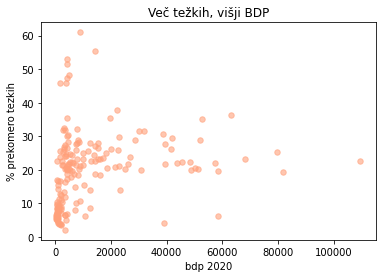

In [70]:
# prekomerno tezki:povprecna starost:bdp
drzave.plot.scatter('bdp 2020', '% prekomero tezkih', s = 30, alpha = 0.6, c = 'lightsalmon', title = 'Več težkih, višji BDP')


#### Višji izobrazbeni indeks, več interneta

<AxesSubplot:title={'center':'BDP pp glede na indeks izobrazbe'}, xlabel='indeks izobrazbe 2015', ylabel='bdp 2020'>

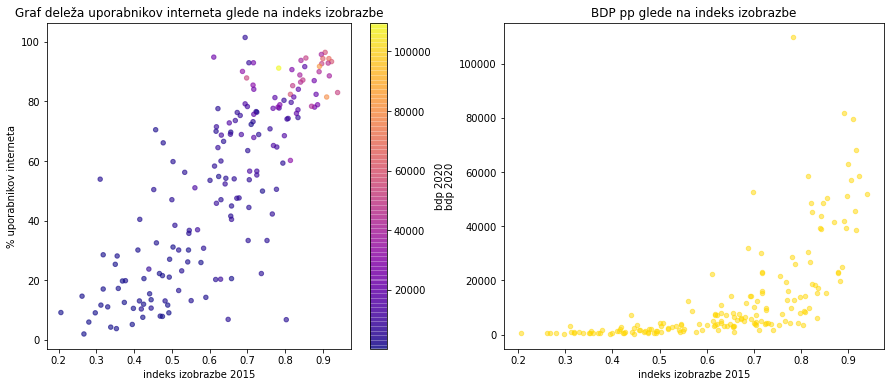

In [159]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
drzave.plot.scatter ('indeks izobrazbe 2015', '% uporabnikov interneta', alpha = 0.6, c = 'bdp 2020', colormap = 'plasma', title = 'Graf deleža uporabnikov interneta glede na indeks izobrazbe', ax=ax1)

drzave.plot.scatter('indeks izobrazbe 2015', 'bdp 2020', alpha = 0.5, c = 'gold', title = 'BDP pp glede na indeks izobrazbe', ax =ax2)




#### Višji BDP, višja izobrazba

<AxesSubplot:title={'center':'neki'}, xlabel='% uporabnikov interneta', ylabel='povprecna starost'>

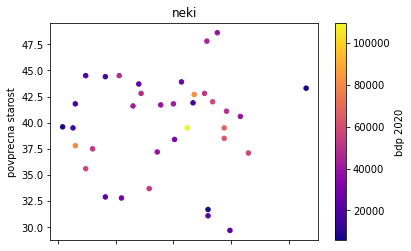

In [172]:
#regresija
drzave[drzave['% uporabnikov interneta'] > 80].plot.scatter('% uporabnikov interneta', 'povprecna starost', title = 'neki', c = 'bdp 2020', colormap = 'plasma')


#### Več težkih, višji BDP

<AxesSubplot:title={'center':'Več težkih, višji BDP'}, xlabel='% prekomero tezkih', ylabel='bdp 2020'>

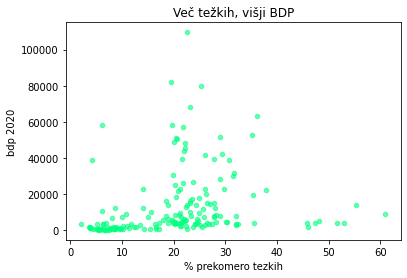

In [100]:
drzave.plot.scatter('% prekomero tezkih', 'bdp 2020', alpha = 0.6, c = 'springgreen', title = 'Več težkih, višji BDP')
#springgreen

<AxesSubplot:title={'center':'aaaa'}, xlabel='% prekomero tezkih', ylabel='st restavracij na 100k ljudi'>

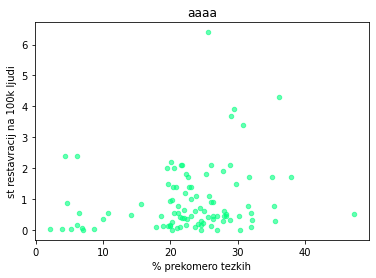

In [156]:
drzave.plot.scatter('% prekomero tezkih', 'st restavracij na 100k ljudi', alpha = 0.6, c = 'springgreen', title = 'aaaa')


#### Starostna struktura, mcdonalds

,drzava,st restavracij na 100k ljudi,povprecna starost
83,Gibraltar,49.6,NaN
4,Andorra,6.4,46.2
144,Monaco,5.2,55.4
233,United States,4.3,38.5
38,Canada,3.9,41.8


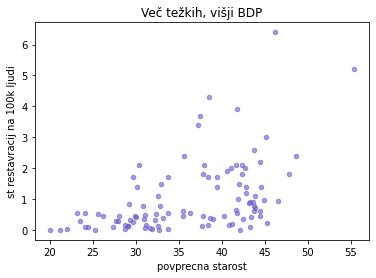

In [148]:
drzave.plot.scatter('povprecna starost', 'st restavracij na 100k ljudi', alpha = 0.6, c = 'slateblue', title = 'Več težkih, višji BDP')
df = drzave.sort_values('st restavracij na 100k ljudi', ascending=False).head(5)
df[['drzava', 'st restavracij na 100k ljudi', 'povprecna starost']]

#### Vnos kalorij, več težkih

Text(0.5, 1.0, 'Povprečni vnos kalorij glede na delež prekomerno težkih')

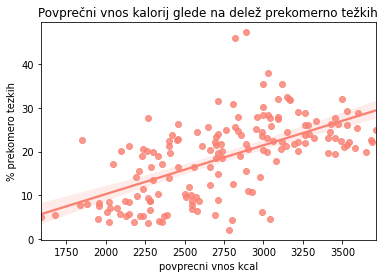

In [151]:
sns.regplot(y='% prekomero tezkih', x='povprecni vnos kcal', data=drzave, color = 'salmon').set_title('Povprečni vnos kalorij glede na delež prekomerno težkih')

#### Višja gostota, večji BDP

<AxesSubplot:title={'center':'Višja gostota, večji BDP'}, xlabel='gostota prebivalstva', ylabel='bdp 2020'>

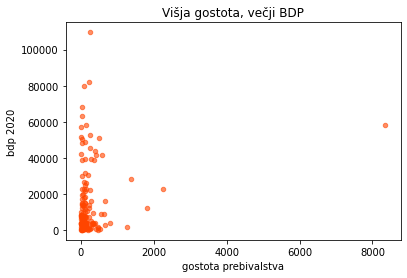

In [177]:
drzave.plot.scatter('gostota prebivalstva', 'bdp 2020', alpha = 0.6, c = 'orangered', title = 'Višja gostota, večji BDP')

<AxesSubplot:xlabel='starost moski', ylabel='starost zenske'>

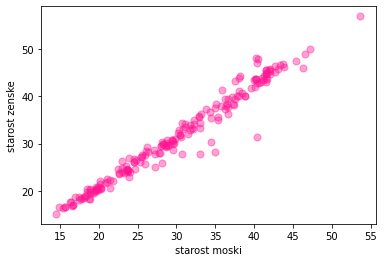

In [183]:
drzave.plot.scatter('starost moski', 'starost zenske', c = 'deeppink', alpha = 0.4, s= 50)#, c = 'slateblue', title = 'Več težkih, višji BDP')
## leta

#### Zemljevidi

In [198]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim